In [36]:
!pip -q install pandas numpy tqdm python-louvain  # add extras when needed
import json, pandas as pd, numpy as np, re, os, textwrap, itertools, collections
import matplotlib.pyplot as plt
from tqdm import tqdm


In [37]:
TACTIC_WHITELIST = [
    "attack.initial_access",
    "attack.execution",
    "attack.persistence",
    "attack.privilege_escalation",
    "attack.defense_evasion",
    "attack.credential_access",
    "attack.discovery",
    "attack.lateral_movement",
    "attack.collection",
    "attack.command_and_control",
    "attack.exfiltration",
    "attack.impact",
    # Some versions have extra ones like:
    "attack.resource_development",  # pre-attack
    "attack.reconnaissance",        # pre-attack
]


In [45]:
RAW_PATH = '/content/enrichment_dataset.json'


def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # keys are numeric strings ("0","1",...) → list
    if isinstance(data, dict) and data.keys() and list(data.keys())[0].isdigit():
        data = [data[k] for k in sorted(data, key=int)]
    return data

raw = load_json(RAW_PATH)
print(f"{len(raw):,} rows")

# flatten nested sigma fields you’ll need later
def flatten(entry):
    tags = entry.get("sigma_rule", {}).get("tags", [])
    # Normalize all tags to lowercase, hyphens→underscores
    norm_tags = [t.lower().replace("-", "_") for t in tags]

    # tactic_ids: Only those matching whitelist, with "attack." prefix stripped
    tactic_ids = [
        t.replace("attack.", "") for t in norm_tags if t in TACTIC_WHITELIST
    ]

    flat = {
        "url":        entry.get("url", ""),
        "markdown":   entry.get("markdown", ""),
        "sigma_tags": tags,
        "tech_ids":   [t for t in tags if t.startswith("attack.t")],
        "tactic_ids": tactic_ids,
    }
    return flat

df = pd.DataFrame([flatten(r) for r in raw])
df.head()


1,030 rows


,url,markdown,sigma_tags,tech_ids,tactic_ids
0,https://posts.specterops.io/requesting-azure-a...,# Requesting Azure AD Request Tokens on Azure-...,"[attack.defense-evasion, attack.privilege-esca...",[attack.t1574.002],"[defense_evasion, privilege_escalation]"
1,https://learn.microsoft.com/en-us/windows/win3...,# MiniDumpWriteDump function (minidumpapiset.h...,"[attack.credential-access, attack.t1003.001]",[attack.t1003.001],[credential_access]
2,https://www.pinvoke.net/default.aspx/dbghelp/M...,# MiniDumpWriteDump (dbghelp)\n\n## Summary\n\...,"[attack.credential-access, attack.t1003.001]",[attack.t1003.001],[credential_access]
3,https://medium.com/@fsx30/bypass-edrs-memory-p...,"# Bypass EDR’s memory protection, introduction...","[attack.credential-access, attack.t1003.001]",[attack.t1003.001],[credential_access]
4,https://www.crowdstrike.com/blog/windows-resta...,,"[attack.impact, attack.defense-evasion, attack...","[attack.t1486, attack.t1562.001]","[impact, defense_evasion]"


In [46]:
df['markdown'] = df['markdown'].replace(r'^\s*$', np.nan, regex=True)
missing_cnt    = df['markdown'].isna().sum()
print("Missing markdown (after strip):", missing_cnt)

Missing markdown (after strip): 153


In [47]:
print("Rows:", len(df))
print("\nMissing markdown:", df['markdown'].isna().sum())
print("Unique URLs:", df['url'].nunique())
print("Entry per URL stats:", df['url'].value_counts().describe())


Rows: 1030

Missing markdown: 153
Unique URLs: 692
Entry per URL stats: count    692.000000
mean       1.488439
std        1.096572
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: count, dtype: float64


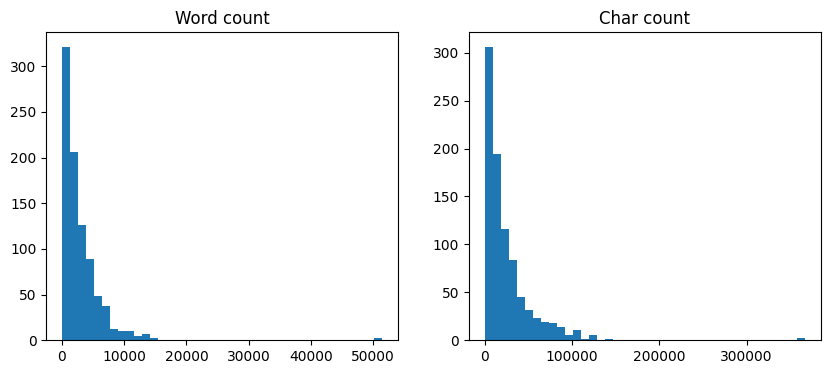

In [48]:
df['word_count'] = df['markdown'].str.split().str.len()
df['char_count'] = df['markdown'].str.len()

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(df['word_count'], bins=40); ax[0].set_title('Word count')
ax[1].hist(df['char_count'], bins=40); ax[1].set_title('Char count')
plt.show()


Unique sigma tags: 177


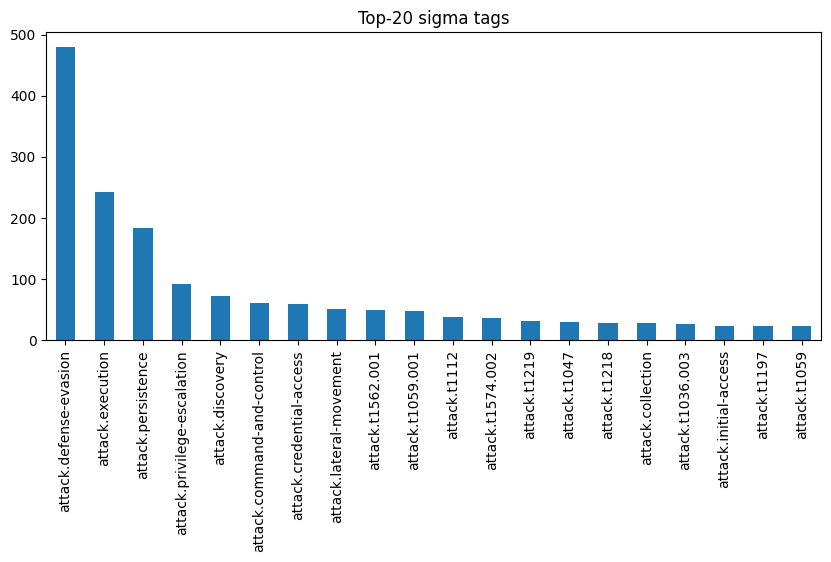

In [49]:
from itertools import chain
all_tags = list(chain.from_iterable(df['sigma_tags']))
tag_freq = pd.Series(all_tags).value_counts()

print(f"Unique sigma tags: {len(tag_freq)}")
tag_freq.head(20).plot(kind='bar', figsize=(10,4), title='Top-20 sigma tags')
plt.show()


Tactics: attack.defense-evasion         480
attack.execution               243
attack.persistence             184
attack.privilege-escalation     92
attack.discovery                72
attack.command-and-control      61
attack.credential-access        59
attack.lateral-movement         51
attack.collection               29
attack.initial-access           24
attack.impact                   22
attack.exfiltration             19
attack.resource-development     14
attack.s0190                    12
attack.g0047                     4
car.2013-07-002                  4
car.2016-04-002                  3
attack.s0108                     3
stp.1u                           3
car.2019-04-001                  2
attack.g0069                     2
attack.s0029                     2
car.2019-04-004                  2
attack.s0592                     1
car.2016-03-001                  1
cve.2021-35211                   1
car.2013-05-004                  1
car.2015-04-001                  1
attack.s000

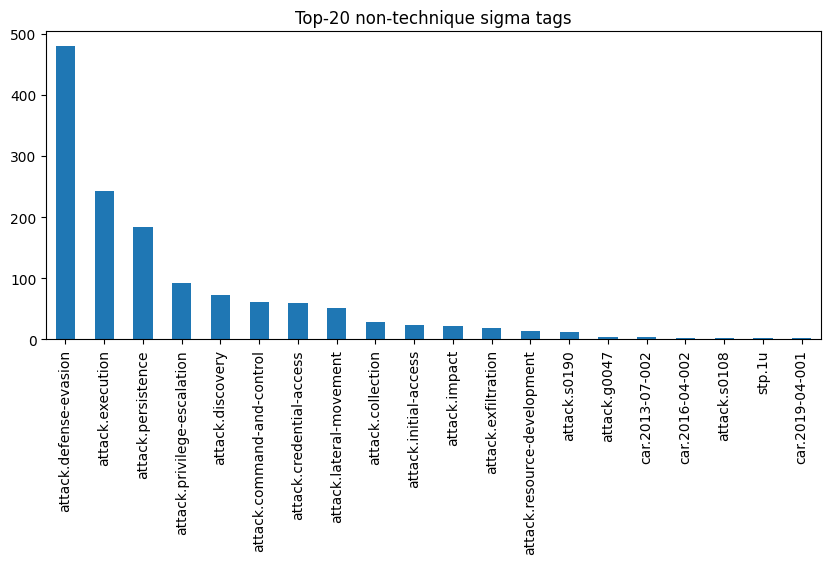

In [50]:
import re

# 1. Pattern to match attack.t<number> (e.g., attack.t1234, attack.t5678.001, etc.)
technique_pattern = re.compile(r"^attack\.t\d+")

# 2. Filter tags that are NOT attack.t<number>
non_technique_tags = [t for t in all_tags if not technique_pattern.match(t)]

# 3. Count frequency
nontech_tag_freq = pd.Series(non_technique_tags).value_counts()
print("Tactics:", nontech_tag_freq)
print(f"Unique non-technique sigma tags: {len(nontech_tag_freq)}")
nontech_tag_freq.head(20).plot(kind='bar', figsize=(10,4), title='Top-20 non-technique sigma tags')
plt.show()


defense_evasion         480
execution               243
persistence             184
privilege_escalation     92
discovery                72
command_and_control      61
credential_access        59
lateral_movement         51
collection               29
initial_access           24
impact                   22
exfiltration             19
resource_development     14
Name: count, dtype: int64


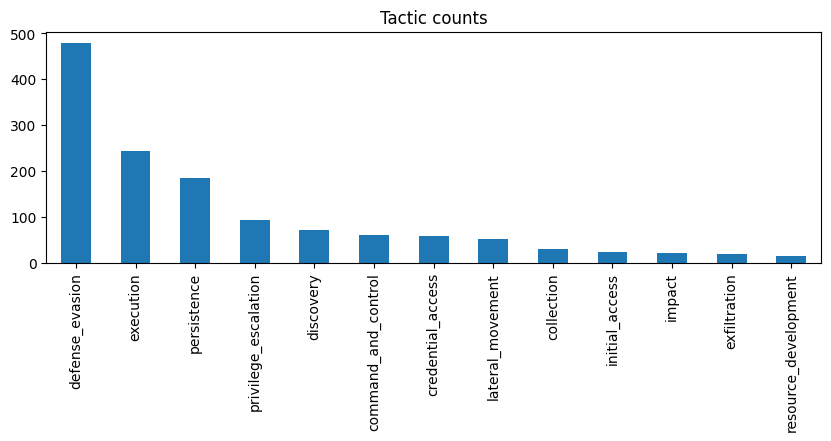

In [54]:
tactic_freq = pd.Series(chain.from_iterable(df['tactic_ids'])).value_counts()
tactic_freq.plot(kind='bar', figsize=(10,3), title='Tactic counts')
print(tactic_freq)
plt.show()


In [55]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tactic_ids'])
tactic_labels = mlb.classes_
print("Tactics:", tactic_labels)

print("Avg tags / sample:", Y.sum(1).mean())
print("Tag imbalance (≥ 1 % rows):", (Y.mean(0) >= .01).sum(), '/', Y.shape[1])

Tactics: ['collection' 'command_and_control' 'credential_access' 'defense_evasion'
 'discovery' 'execution' 'exfiltration' 'impact' 'initial_access'
 'lateral_movement' 'persistence' 'privilege_escalation'
 'resource_development']
Avg tags / sample: 1.3106796116504855
Tag imbalance (≥ 1 % rows): 13 / 13


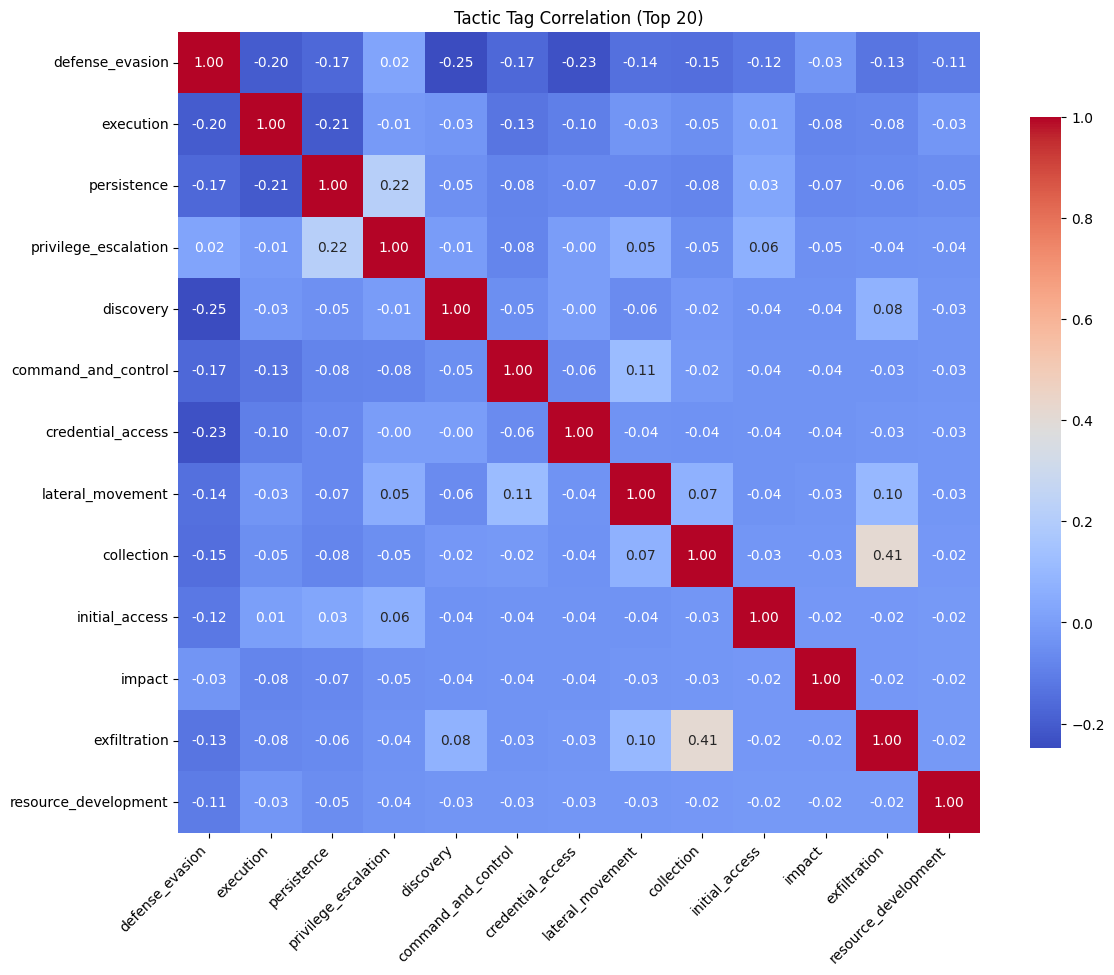

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For the top N most frequent tactics:
N = 20
tactic_counts = pd.Series(Y.sum(axis=0), index=tactic_labels)
top_tactics = tactic_counts.nlargest(N).index.tolist()

# DataFrame with just those columns
Y_df = pd.DataFrame(Y, columns=tactic_labels)
Y_top = Y_df[top_tactics]

# Correlation matrix
corr = Y_top.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=top_tactics,
            yticklabels=top_tactics,
            square=True, cbar_kws={"shrink": 0.75})
plt.title("Tactic Tag Correlation (Top 20)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [57]:
g_counts = df.groupby('url')['tactic_ids'].apply(lambda l: set(chain(*l)))
print("URLs having >1 distinct tactic sets:", (g_counts.str.len() > 1).sum())


URLs having >1 distinct tactic sets: 232


In [58]:
label_counts = df['tactic_ids'].apply(len).value_counts().sort_index()
print("Label count distribution per row:")
print(label_counts)


Label count distribution per row:
tactic_ids
0      6
1    751
2    229
3     39
4      1
5      4
Name: count, dtype: int64
